# KNN Regression Algorithm - Raw Data Training

In [44]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [45]:
DATE_TIME_COLUMNS = ['DATETIME_INI', 'DATETIME_FIM']

ds = pd.read_csv('../../../data/dataset.csv', index_col='PES_ID', parse_dates=DATE_TIME_COLUMNS)

## Required Preprocessing

In [46]:
ds["DATETIME_INI"] = ds["DATETIME_INI"].apply(lambda x: time.mktime(x.timetuple()))
ds["DATETIME_FIM"] = ds["DATETIME_FIM"].apply(lambda x: time.mktime(x.timetuple()))

In [ ]:
ds.info()

In [48]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
ds['TPVEICULO_DESC'] = label_encoder.fit_transform(ds['TPVEICULO_DESC'])
ds['TPCIRCUITO_DESC'] = label_encoder.fit_transform(ds['TPCIRCUITO_DESC'])
ds['ROTA_ID'] = label_encoder.fit_transform(ds['ROTA_ID'])
ds['ROTA_DESC'] = label_encoder.fit_transform(ds['ROTA_DESC'])
ds['LOCDESCARREGO_DESC'] = label_encoder.fit_transform(ds['LOCDESCARREGO_DESC'])
ds['LOCAL_NOME'] = label_encoder.fit_transform(ds['LOCAL_NOME'])
ds['COLETA_DESC'] = label_encoder.fit_transform(ds['COLETA_DESC'])
ds['ESPECCOLETA_DESC'] = label_encoder.fit_transform(ds['ESPECCOLETA_DESC'])
ds['EMP_NOME'] = label_encoder.fit_transform(ds['EMP_NOME'])


In [ ]:
ds.info()

## Training

In [50]:
target_column_name = 'PES_PESOUTIL'
target_column = ds.pop(target_column_name)

In [51]:
X = ds.to_numpy()
y = target_column.to_numpy()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
params = {'algorithm': 'ball_tree',
          'leaf_size': 30,
          'n_neighbors': 100,
          'weights': 'distance',
          'p': 1
}

In [54]:
knn = KNeighborsRegressor(**params)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=100, p=1,
                    weights='distance')

In [55]:
train_preds = knn.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)
train_rmse = math.sqrt(train_mse)
train_rmse

0.0

In [56]:
test_preds = knn.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = math.sqrt(test_mse)
test_rmse

2927.307091571861

# Cross Validation

In [57]:
import random
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

def cross_validate_model(model, X, y, cv=10):
    cv = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=random.randint(0, 1000))
    n_scores = cross_validate(estimator=model,
                            X=X,
                            y=y,
                            cv=cv,
                            scoring=('r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                            return_train_score=True
                            )
    return n_scores

In [58]:
N_ITERATIONS = 5
N_CROSS_VALIDATION = 10

n_scores = []
duration = []

for _ in range(N_ITERATIONS):
    time_start = time.time()
    n_scores.append(cross_validate_model(knn, X, y, cv=N_CROSS_VALIDATION))
    duration.append(time.time() - time_start)

In [ ]:
# print(n_scores)

### Training Duration

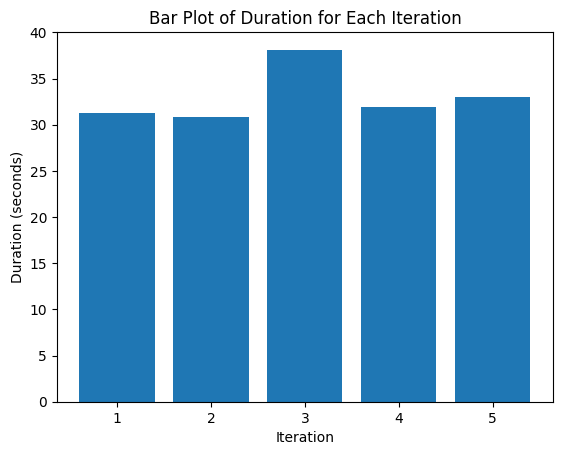

In [60]:
# Create a bar plot
plt.bar(range(1,len(duration)+1), duration)
plt.xlabel('Iteration')
plt.ylabel('Duration (seconds)')
plt.title('Bar Plot of Duration for Each Iteration')
plt.show()

### R² Score

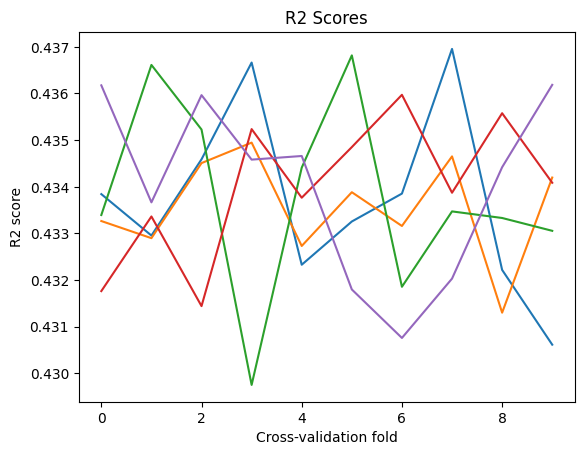

In [61]:
# Reshape the R2 scores
r2_scores = [r2['test_r2'].reshape(-1, 1) for r2 in n_scores]

# Plot the R2 scores
[plt.plot(r2_score, label=f'Fold {i + 1}') for i, r2_score in enumerate(r2_scores)]
plt.xlabel('Cross-validation fold')
plt.ylabel('R2 score')
plt.title('R2 Scores')
plt.show()

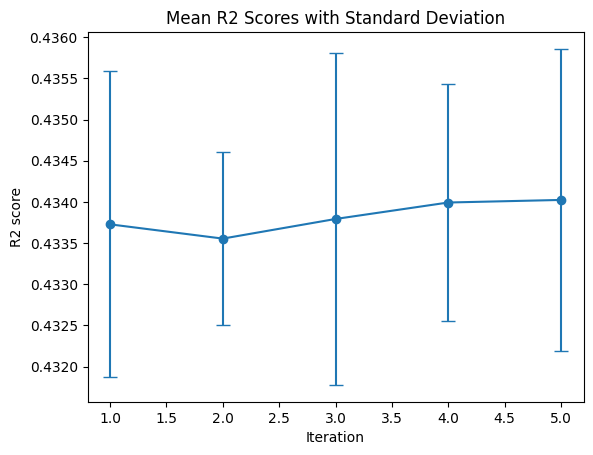

Mean R2: 0.4338
Standard Deviation of R2: 0.0002


In [62]:
# Calculate mean and standard deviation of R2 scores
mean_r2_scores = [r2['test_r2'].mean() for r2 in n_scores]
std_r2_scores = [r2['test_r2'].std() for r2 in n_scores]

# Plot the mean R2 scores with error bars representing the standard deviation
plt.errorbar(range(1, N_ITERATIONS + 1), mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('Iteration')
plt.ylabel('R2 score')
plt.title('Mean R2 Scores with Standard Deviation')
plt.show()

mean_r2 = sum(mean_r2_scores) / len(mean_r2_scores)
std_mse = np.std(mean_r2_scores)

print("Mean R2: {:.4f}".format(mean_r2))
print("Standard Deviation of R2: {:.4f}".format(std_mse))

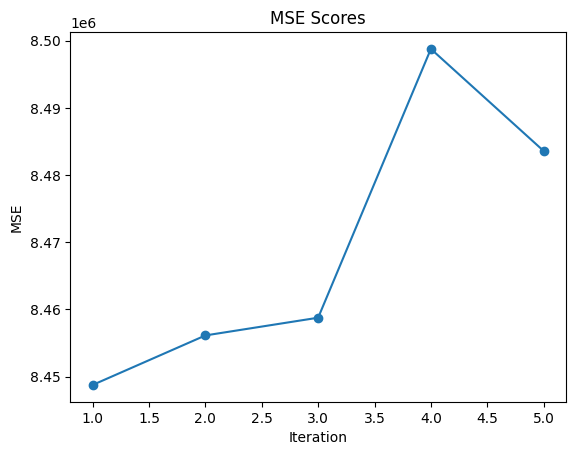

Mean MSE: 8469215.4461
Standard Deviation of MSE: 18860.8053


In [63]:
# Calculate MSE for each fold
mse_scores = [-r2['test_neg_mean_squared_error'].mean() for r2 in n_scores]

# Plot the MSE scores
plt.plot(range(1, N_ITERATIONS + 1), mse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE Scores')
plt.show()

# Calculate mean and standard deviation of MSE scores
mean_mse = sum(mse_scores) / len(mse_scores)
std_mse = np.std(mse_scores)

print("Mean MSE: {:.4f}".format(mean_mse))
print("Standard Deviation of MSE: {:.4f}".format(std_mse))

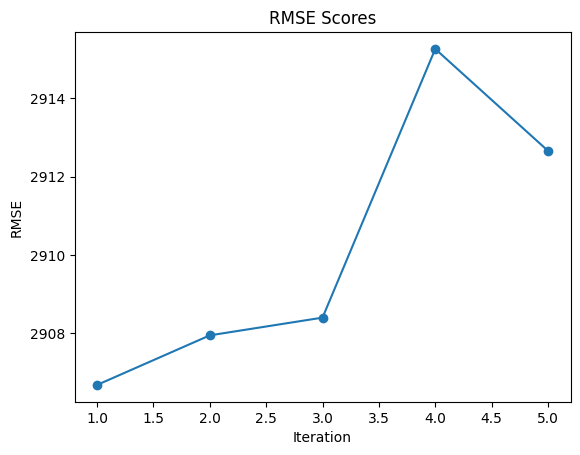

Mean RMSE: 2910.1898
Standard Deviation of RMSE: 3.2396


In [64]:
rmse_scores = [np.sqrt(-r2['test_neg_mean_squared_error'].mean()) for r2 in n_scores]

# Plot the RMSE scores
plt.plot(range(1, N_ITERATIONS + 1), rmse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Scores')
plt.show()

# Calculate mean and standard deviation of RMSE scores
mean_rmse = sum(rmse_scores) / len(rmse_scores)
std_rmse = np.std(rmse_scores)

print("Mean RMSE: {:.4f}".format(mean_rmse))
print("Standard Deviation of RMSE: {:.4f}".format(std_rmse))